# Objective
    1) Predict images with/without defect(s)
    2) set the predicted images without defects to Nan
This kernel has memory problem. Solution: data_generator

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

In [2]:
train = pd.read_csv('./input/train.csv')
print("train.shape:", train.shape)
train.head()

train.shape: (50272, 2)


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


# Preprocessing

## 1) Split into ImageId, ClassId

In [3]:
train['ImageId'] = train['ImageId_ClassId'].str[:-2]
train['ClassId'] = train['ImageId_ClassId'].str[-1:]
train['defect'] = train['EncodedPixels'].notnull()

train = train[['ImageId','ClassId','defect','EncodedPixels']]

In [4]:
print('{} = no. of train_images * 4'.format(train.shape[0]))
print('train.shape:', train.shape)
train.head()

50272 = no. of train_images * 4
train.shape: (50272, 4)


,ImageId,ClassId,defect,EncodedPixels
0,0002cc93b.jpg,1,True,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg,2,False,NaN
2,0002cc93b.jpg,3,False,NaN
3,0002cc93b.jpg,4,False,NaN
4,00031f466.jpg,1,False,NaN


# y_train (image with/without defect(s))

In [5]:
y_train = train.groupby(by='ImageId', axis=0, as_index=False).agg({'defect':'max'})

In [6]:
print('There are {} train_images in total'.format(y_train.shape[0]))
print('train.shape:', y_train.shape)
y_train.head(10)

There are 12568 train_images in total
train.shape: (12568, 2)


,ImageId,defect
0,0002cc93b.jpg,True
1,00031f466.jpg,False
2,000418bfc.jpg,False
3,000789191.jpg,False
4,0007a71bf.jpg,True
5,000a4bcdd.jpg,True
6,000f6bf48.jpg,True
7,0014fce06.jpg,True
8,001982b08.jpg,False
9,001d1b355.jpg,False


True     6666
False    5902
Name: defect, dtype: int64


Text(0, 0.5, 'No. of images')

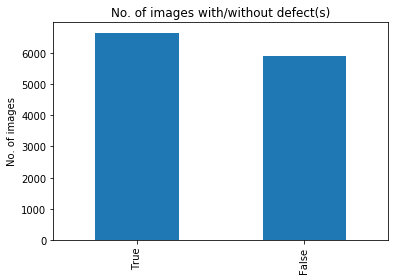

In [7]:
print(y_train['defect'].value_counts())

y_train['defect'].value_counts().plot(kind='bar')
plt.title("No. of images with/without defect(s)")
plt.ylabel("No. of images")

# sample_submission

In [8]:
sample_submission = pd.read_csv("./input/sample_submission.csv")
print("sample_submission.shape:", sample_submission.shape)
sample_submission.head()

sample_submission.shape: (7204, 2)


,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,1 1
1,004f40c73.jpg_2,1 1
2,004f40c73.jpg_3,1 1
3,004f40c73.jpg_4,1 1
4,006f39c41.jpg_1,1 1


## 1) Split into ImageId, ClassId

In [9]:
sample_submission['ImageId'] = sample_submission['ImageId_ClassId'].str[:-2]
sample_submission['ClassId'] = sample_submission['ImageId_ClassId'].str[-1:]
sample_submission['defect'] = 0

sample_submission = sample_submission[['ImageId','ClassId','defect']]

In [10]:
print('{} = no. of test_images * 4'.format(sample_submission.shape[0]))
print('sample_submission.shape:', sample_submission.shape)
sample_submission.head()

7204 = no. of test_images * 4
sample_submission.shape: (7204, 3)


,ImageId,ClassId,defect
0,004f40c73.jpg,1,0
1,004f40c73.jpg,2,0
2,004f40c73.jpg,3,0
3,004f40c73.jpg,4,0
4,006f39c41.jpg,1,0


## 2) Groupby 'ImageId'

In [11]:
sample_submission = sample_submission.groupby(by='ImageId', axis=0, as_index=False).agg({'defect':'max'})

In [12]:
print('There are {} test_images in total'.format(sample_submission.shape[0]))
print('sample_submission.shape:', sample_submission.shape)
sample_submission.head()

There are 1801 test_images in total
sample_submission.shape: (1801, 2)


,ImageId,defect
0,004f40c73.jpg,0
1,006f39c41.jpg,0
2,00b7fb703.jpg,0
3,00bbcd9af.jpg,0
4,0108ce457.jpg,0


# x_train (Train images)

In [13]:
def keras_generator(batch_size):
    
    img_size = 256
    file_path = "./input/train_images/"   # train file path
    
    while True:
        x_batch = []
        y_batch = []

        for i in range(batch_size):
            img = cv2.imread(file_path + str(y_train['ImageId'].iloc[i]))
            print(y_train['ImageId'].iloc[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            
            img = cv2.resize(img, (img_size, img_size))

            x_batch += [img]   # x_batch.append(img)

        x_batch = np.array(x_batch)
        y_batch = y_train['defect'][:batch_size].values


        yield x_batch, y_batch

In [16]:
i=0
for x, y in keras_generator(4):
    i += 1
    print(x.shape, y.shape)
    if i>3:
        break

y

0002cc93b.jpg
00031f466.jpg
000418bfc.jpg
000789191.jpg
(4, 256, 256, 3) (4,)
0002cc93b.jpg
00031f466.jpg
000418bfc.jpg
000789191.jpg
(4, 256, 256, 3) (4,)
0002cc93b.jpg
00031f466.jpg
000418bfc.jpg
000789191.jpg
(4, 256, 256, 3) (4,)
0002cc93b.jpg
00031f466.jpg
000418bfc.jpg
000789191.jpg
(4, 256, 256, 3) (4,)


array([ True, False, False, False])

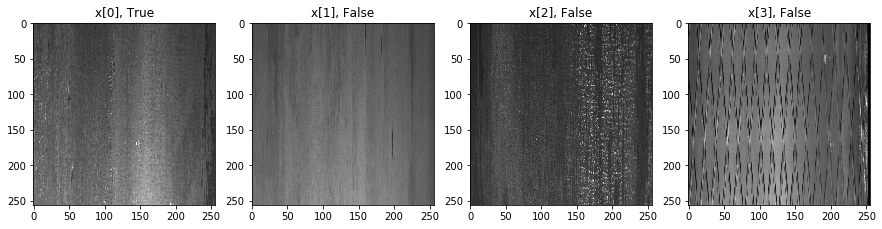

In [13]:
# Using keras_generator
columns = 4
rows = 1

fig = plt.figure(figsize=(15,10))
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1).set_title("x["+str(i)+'], '+str(y[i]))
    plt.imshow(x[i])
plt.show()

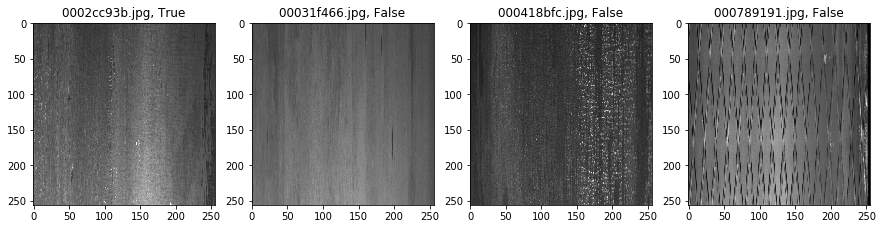

In [14]:
# double check
columns = 4
rows = 1

img_size = 256
file_path = "./input/train_images/"   # train file path

fig = plt.figure(figsize=(15,10))
for i in range(columns*rows):
    img = cv2.imread(file_path + str(y_train['ImageId'].iloc[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            
    img = cv2.resize(img, (256, 256))
    
    fig.add_subplot(rows, columns, i+1).set_title(str(y_train['ImageId'].iloc[i]) + ', ' + str(y_train['defect'].iloc[i]))
    
    plt.imshow(img)
plt.show()

# Model in Keras

In [ ]:
history = model.fit_generator(keras_generator(BATCH_SIZE),
                              steps_per_epoch=len(df_train.index)/EPOCHS,                    
                              epochs=EPOCHS,                    
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
)

# x_test (Test images)

In [23]:
# test file path
img_path = "./input/test_images/"

file_paths = []
for i in range(sample_submission.shape[0]):
    file_paths.append(img_path + str(sample_submission['ImageId'].iloc[i]))

print("len(file_paths):", len(file_paths))
file_paths[:5]

len(file_paths): 1801


['./input/test_images/004f40c73.jpg',
 './input/test_images/006f39c41.jpg',
 './input/test_images/00b7fb703.jpg',
 './input/test_images/00bbcd9af.jpg',
 './input/test_images/0108ce457.jpg']

In [34]:
# test images -> array

%%time
img_size = 256
x = []

for i, file_path in enumerate(file_paths):
    img = cv2.imread(file_path)                                  # read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                   # convert color
    img = cv2.resize(img, (img_size, img_size))                  # resize
    img = img/255.0                                              # normalization
    
    x.append(img)

x_test = np.array(x)

In [37]:
print("x_test.shape:", x_test.shape)
print('x_test[0].shape:', x_test[0].shape)
plt.imshow(x_test[0])

x_test.shape: (1801, 256, 256, 3)


array([[[45, 45, 45],
        [48, 48, 48],
        [58, 58, 58],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[45, 45, 45],
        [46, 46, 46],
        [56, 56, 56],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[47, 47, 47],
        [47, 47, 47],
        [52, 52, 52],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       ...,

       [[77, 77, 77],
        [69, 69, 69],
        [74, 74, 74],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[77, 77, 77],
        [55, 55, 55],
        [65, 65, 65],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 2,  2,  2]],

       [[77, 77, 77],
        [58, 58, 58],
        [64, 64, 64],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 2,  2,  2]]], dtype=uint8)

# Prediction

In [ ]:
%%time

BATCH_SIZE=16

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(
    np.asarray(x_test),
    batch_size=BATCH_SIZE
)

testfiles=os.listdir("../input/severstal-steel-defect-detection/test_images/")
nb_samples = len(testfiles)
y_pred = model.predict_generator(test_generator, steps = sample_submission.shape[0]/BATCH_SIZE)